In [12]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
import matplotlib.pyplot as plt
import networkx as nx

Load one of DGL's built in datasets:

In [13]:
dataset = dgl.data.CoraGraphDataset()
graph = dataset[0] # We are using the first graph in the dataset
print(graph)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={'__orig__': Scheme(shape=(), dtype=torch.int64)})


In [14]:
print(graph.ndata)

{'train_mask': tensor([False, False, False,  ..., False, False, False]), 'label': tensor([4, 4, 4,  ..., 4, 3, 3]), 'val_mask': tensor([False, False,  True,  ..., False, False, False]), 'test_mask': tensor([ True,  True, False,  ..., False, False, False]), 'feat': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0526, 0.0000]])}


The graph contains the following node features:

 - train_mask: A boolean tensor indicating whether the node is in the training set.

 - val_mask: A boolean tensor indicating whether the node is in the validation set.

 - test_mask: A boolean tensor indicating whether the node is in the test set.

 - label: The ground truth node category.

 - feat: The node features.

In [15]:
print(graph.edata)

{'__orig__': tensor([  298,  9199,  1153,  ..., 10415,  5255,  6356])}


Convert graph to NetworkX to plot it 

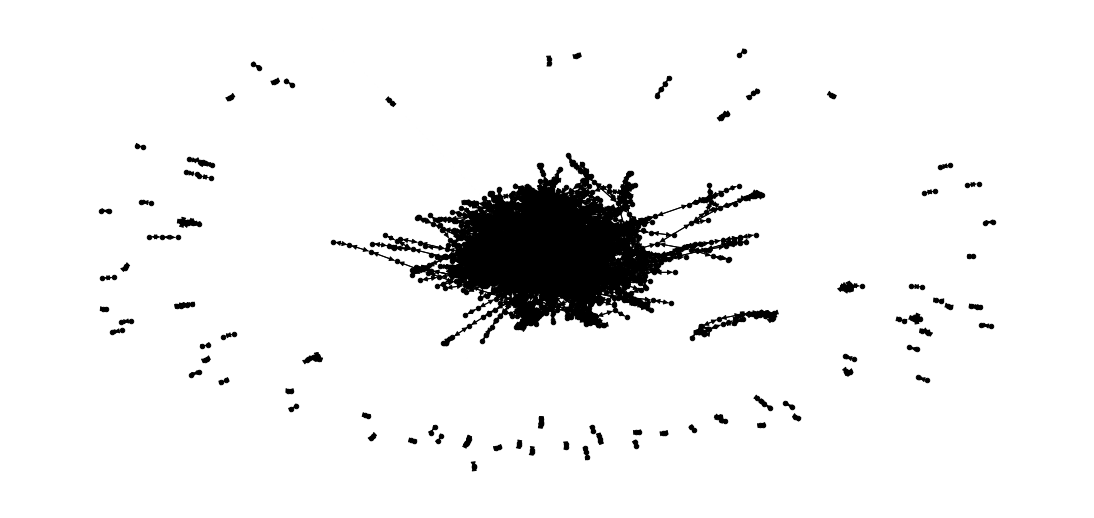

In [16]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
nx_graph = dgl.to_networkx(graph)
plt.figure(figsize=[15,7])
nx.draw(nx_graph, **options)

Building multi-layer GCN: 

In [17]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [18]:
# Create the model with given dimensions
model = GCN(graph.ndata['feat'].shape[1], 16, dataset.num_classes).to('cuda')

Training the model:

In [19]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    
    for i in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                i, 
                loss, 
                val_acc,
                best_val_acc,
                test_acc,
                best_test_acc
                )
            )

graph = graph.to('cuda')
train(graph, model)

In epoch 0, loss: 1.946, val acc: 0.126 (best 0.126), test acc: 0.118 (best 0.118)
In epoch 5, loss: 1.891, val acc: 0.664 (best 0.664), test acc: 0.693 (best 0.693)
In epoch 10, loss: 1.810, val acc: 0.706 (best 0.706), test acc: 0.736 (best 0.736)
In epoch 15, loss: 1.705, val acc: 0.736 (best 0.736), test acc: 0.755 (best 0.755)
In epoch 20, loss: 1.575, val acc: 0.736 (best 0.746), test acc: 0.763 (best 0.756)
In epoch 25, loss: 1.424, val acc: 0.750 (best 0.750), test acc: 0.763 (best 0.763)
In epoch 30, loss: 1.256, val acc: 0.754 (best 0.754), test acc: 0.765 (best 0.765)
In epoch 35, loss: 1.080, val acc: 0.754 (best 0.756), test acc: 0.770 (best 0.766)
In epoch 40, loss: 0.907, val acc: 0.760 (best 0.760), test acc: 0.771 (best 0.772)
In epoch 45, loss: 0.745, val acc: 0.760 (best 0.762), test acc: 0.776 (best 0.772)
In epoch 50, loss: 0.603, val acc: 0.758 (best 0.762), test acc: 0.775 (best 0.772)
In epoch 55, loss: 0.484, val acc: 0.764 (best 0.764), test acc: 0.776 (best 0

: 